# Filtering low quality cells in scATAC-seq data

## The dataset

To showcase the processing of scATAC-seq data, we use a 10x Multiome data set generated for a single cell data integration challenge at the NeurIPS conference 2021 {cite:p}`luecken2021sandbox`. A hallmark of this data set is that it contains a nested batch structure of multiple donors sequenced at multiple institutions.

Our starting point for this notebook is the output of cellranger-arc, the software solution of 10x to perfom alignment, peak calling and initial QC of their 10x Multiome assay.  By default, the output contains the snRNA-seq as well as the scATAC-seq data. Since the preprocessing of scRNA-seq or snRNA-seq data has been described extensively in previous chapters, here, we load the multimodal data, but only discuss the processing of the chromatin accesibility data.

## Import packages

We start with loading all neccessary packages for our analysis and setting figure parameters and the working directory.

In [1]:
# Scanpy and general useful python packages
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np

# To create customised plots
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries to work with multimodal data
import muon as mu
from muon import atac as ac   # the module containing function for scATAC data processing

In [2]:
# Setting figure parameters
from matplotlib import rcParams
rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

In [3]:
# Check the current working directory
os.getcwd()

'/lustre/groups/ml01/workspace/christopher.lance/extended-single-cell-best-practices/jupyter-book/multi_omics'

In [4]:
# In case you would like to change the working directory
os.chdir('/lustre/groups/ml01/workspace/christopher.lance/extended-single-cell-best-practices/jupyter-book/multi_omics/')

# Loading the data

Our staring point is the output directory of ```cellranger-arc aggr```, which harmonizes features (peaks) across all samples within our analysis. The primary file we load is the filtered_feature_bc_matrix.h5 file containing the cell-by-peak count matrix. During loading, we leverage the functionality of ```moun``` to automatically detect the corresponding fragment and peak annotation files within the same directory.

In [5]:
mdata = mu.read_10x_h5("/lustre/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/filtered_feature_bc_matrix.h5")

/lustre/groups/ml01/workspace/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /lustre/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/filtered_feature_bc_matrix.h5


/lustre/groups/ml01/workspace/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/lustre/groups/ml01/workspace/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/mudata/_core/mudata.py:437: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from /lustre/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /lustre/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/atac_fragments.tsv.gz


As the warning messages indicate, peak identifiers are not unique. To prevent issues in downstrem analysis steps, we make them unique using the ```.var_names_make_unique()``` function.

In [6]:
mdata.var_names_make_unique()

Next, let's take a look into the MuData object we just generated (the data structure is described in detail in chapter **XXX**). First, as a compact text output and, second, as an interactive HTML output.

In [7]:
# Printed as compact text output
mdata

MuData object with n_obs × n_vars = 131515 × 194756
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	131515 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	131515 x 158155
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [8]:
# Printed as intective html
with mu.set_options(display_style = "html", display_html_expand = 0b000):
    display(mdata)

rna,bool,numpy.ndarray,
atac,bool,numpy.ndarray,
atac,collections.OrderedDict,1 element,peak_annotation: DataFrame (201507 x 3)
files,collections.OrderedDict,1 element,fragments: /lustre/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/atac_fragments.tsv.gz


As we can see, both modalities (snRNA and ATAC) have been loaded as two AnnData objects. The ATAC modality contains two entries in the unstructured data slot (atac.uns) that contain the peak annotation and the path to the fragment file automatically added by muon.

Let's take a look at the atac.uns slot, printing the peak annotation and path to the fragment file.

In [9]:
mdata.mod['atac'].uns

OverloadedDict, wrapping:
	OrderedDict([('atac', OrderedDict([('peak_annotation',                                peak  distance peak_type
gene_name                                              
MIR1302-2HG         chr1:9776-10668    -18886    distal
AL627309.5       chr1:180726-181005     -6865    distal
AL627309.5       chr1:181117-181803     -7256    distal
AL627309.5       chr1:183983-184830    -10122    distal
AL627309.5       chr1:191133-192055    -17272    distal
...                             ...       ...       ...
AC233755.1   KI270726.1:41476-42297        33  promoter
AC213203.2   KI270713.1:21434-22336     10192    distal
AC213203.2   KI270713.1:26002-26720      5808    distal
AC213203.2   KI270713.1:29629-30491      2037    distal
AC213203.1   KI270713.1:36926-37828      1520    distal

[201507 rows x 3 columns])])), ('files', OrderedDict([('fragments', '/lustre/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/atac_fragments.tsv.

By loading the peak annotation file provided as part of the cellranger output we already have a first idea which genes might be affected by the given peak. However, this is only based on the distance to the closest gene and should be considered with care.

To add informative sample descriptors, we load the data table used to aggregate the samples in ```cellranger arc aggr```. During the aggregated peak calling, cell barcodes were extended with an index corresponding to the sample. This we use to map meaningful sample descriptors as a combination of the site and donor the sample was processed and received, respectively. Additionally, we split up the sample names into its components, to get the site and donor information seperately.

In [10]:
meta_dat = pd.read_csv('/lustre/groups/ml01/datasets/projects/20220323_neurips21_bmmc_christopher.lance/multiome/aggr_donors/aggr.csv')

In [11]:
# Printing the first rows to check the data
meta_dat.head()

,library_id,atac_fragments,per_barcode_metrics,gex_molecule_info
0,site1_donor1,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...
1,site1_donor2,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...
2,site1_donor3,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...
3,site2_donor1,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...
4,site2_donor4,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...,/mnt/6ab45c49-915d-429c-a035-6211f2abf11a/data...


In [12]:
# The tags added to the cell barcodes are 1 to 14, therefore we create a list starting from 1
cell_tags = [str(i+1) for i in list(meta_dat.index)]
# format 'site1'
site_list = [s.split('_')[0] for s in meta_dat['library_id']]
# format 'donor1'
donor_list = [s.split('_')[1] for s in meta_dat['library_id']]
# format 's1d1'
sample_list = ['s'+s.split('_')[0][4:]+'d'+s.split('_')[1][5:] for s in meta_dat['library_id']]

# creating dictionaries to map sample tags to site, donor and batch (site and donor combined)
site_dict = dict(zip(cell_tags, site_list))
donor_dict = dict(zip(cell_tags, donor_list))
sample_dict = dict(zip(cell_tags, sample_list))

In [13]:
# extracting the sample tag from the barcodes
mdata.obs['samle_tag'] = [s.split('-')[1] for s in list(mdata.obs_names)]

In [14]:
# Mapping 
mdata.obs['site'] = [site_dict[i] for i in mdata.obs['samle_tag']]
mdata.obs['donor'] = [donor_dict[i] for i in mdata.obs['samle_tag']]
mdata.obs['sample'] = [batch_dict[i] for i in mdata.obs['samle_tag']]

# Data QC

A crucial part of every single-cell analysis, is the removal of low-quality cells, so they don't add non-meaningful noise to our downstrem analysis. To do so, we need to define metrics, that allow us to seperate high quality from low-quality cells. Here is an overview of the primary QC metrics used across several scATC-seq processing pipelines:
- **total_fragment_counts**: Total number of fragments per cell representing cellular sequencing depth. This metric is analogous to the number of total counts in scRNA-seq data.
- **tss_enrichment**: Transcriptional start site (TSS) enrichment score, which is the ratio of fragments centered at the TSS to fragments in TSS-flanking regions. This metric can be interpreted as a signal-to noise ratio of each cell.
- **n_features_per_cell**: The number of peaks with non-zero counts in each cell. This metric is analogous to the number of genes detected in scRNA-seq data.
- **nucleosome_signal**: The nucleosome signal referes to the ratio of mononucleosomal to nucloesome-free fragments and can also be interpreted as a signal-to-noise ratio in each cell (more details below).

Additional metrics that can be considered:
- **reads_in_peaks_frac:** The fraction of fragments in peak regions versus fragments outside of peaks. Again, an indicator for the signal-to-noise ratio.
- **blacklist_fraction:** The ratio of reads in genomic blacklist regions, which have been associated with artefactual signal (defined by ENCODE). Benchmarking studies of single-cell ATAC-seq data processing have suggested, that often the mapping of reads to blacklist regions is not a major issue {cite:p}`luecken2021sandbox`.

Additionally on can consider the number of cells per sample, as a sample level QC metric.


## Subsetting to the ATAC modality
To calculate QC metrics we extract the ATAC modality from our MuData object and from here onwards, our analysis primarily uses the obtained AnnData object.

In [15]:
# extract the atac AnnData object
atac = mdata.mod['atac']

## Calculating QC metrics

First, we make use of the calculate_qc_metrics function in scanpy to calculate the total number of fragments and number of features per cell. Second, we log-transform the total counts as an additional representation often suitable for plotting. Third, we modify the variable names to make them suitable for scATAC-seq data, i.e. ```total_counts``` becomes ```total_fragment_counts``` and ```n_genes_by_counts``` becomes the more general ```n_features_per_cell```.

### Total count and number of features

In [16]:
# Calculate general qc metrics using scanpy
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

# Rename columns
atac.obs.rename(columns = {'n_genes_by_counts':'n_features_per_cell', 'total_counts':'total_fragment_counts'}, inplace = True)

# log-transform total counts
atac.obs['log_total_fragment_counts'] = np.log10(atac.obs['total_fragment_counts'])

### Nucleosome signal

Next, we calculate scATAC specific QC metrics, the nucleosome signal and TTS enrichment score.

For the nucleosome signal, the default number of fragments n per cell used to calculate the metric is 10e4*n_cells. Since this would take several hours to calculate, we reduce it by a factor of 10, which still returns a good estimate for the metric.

In [17]:
# TEMP!!! LOAD from file
#mdata_temp = mu.read_h5mu('/lustre/groups/ml01/workspace/christopher.lance/mm_best/src/scATAC/muon_data/neurips_incl_qc_allsamp.h5mu')
#mdata_temp.var_names_make_unique()
#mdata_temp

/lustre/groups/ml01/workspace/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/lustre/groups/ml01/workspace/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/mudata/_core/mudata.py:437: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


In [20]:
# TEMP!!!
#atac_temp = mdata_temp.mod['atac']
#atac.obs['nucleosome_signal'] = atac_temp.obs['nucleosome_signal']

In [15]:
# Calculate the nucleosome signal across cells
ac.tl.nucleosome_signal(atac, n=10e3*atac.n_obs) #set n=10e3*atac.n_obs for rough estimate but faster run time

Reading Fragments: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1315150000/1315150000 [57:39<00:00, 380199.11it/s]


First, let's take a look at the overall distribution of the nucleome signal.

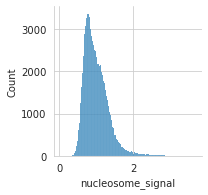

In [22]:
# Plot distribution of the nucleosome_signal across all cells
mu.pl.histogram(atac, "nucleosome_signal")

# Alternatively as a violin plot (uncomment to plot)
#sc.pl.violin(atac, "nucleosome_signal")

The obtained scores range from 0 to about 3. As a rule of thumb, previous anaylysis projects choose between 2 and 4 as a cut-off for low quality cells. To understand better what this score refers to, let's take a closer look at cells with high versus low nucleosome signals. To do so, we add a column to atac.obs, which contains a category for the two classes and plot the distribution of fragment lengths for each.

In [23]:
# One can check  different nucleosome signal thresholds to see when a difference between high and low quality cells can be observed
nuc_signal_threshold = 3
atac.obs['nuc_signal_filter'] = ['NS_FAIL' if ns > nuc_signal_threshold else 'NS_PASS' for
                                 ns in atac.obs['nucleosome_signal'] ]

# Print number cells not passing nucleosome signal threshold
atac.obs['nuc_signal_filter'].value_counts()

NS_PASS    131471
NS_FAIL        44
Name: nuc_signal_filter, dtype: int64

Fetching Regions...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.42s/it]


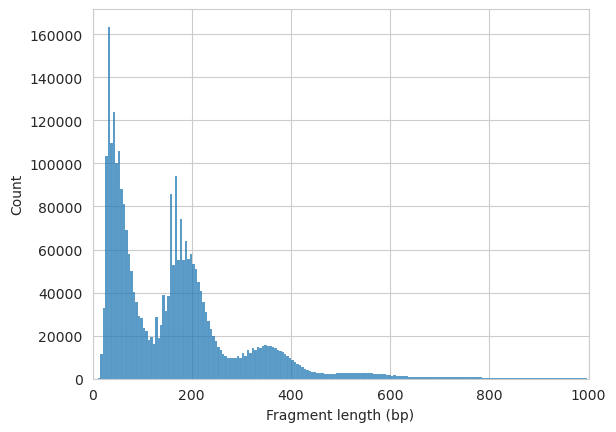

In [24]:
# Plot fragment size distribution
ac.pl.fragment_histogram(atac[atac.obs['nuc_signal_filter']=='NS_PASS'],
                         region="chr1:1-2000000")

Fetching Regions...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.47s/it]


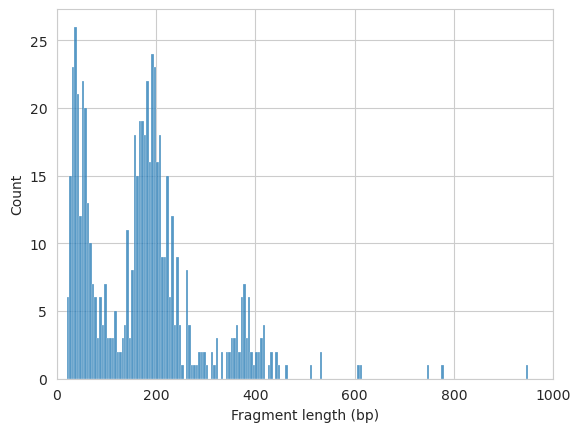

In [25]:
# Plot fragment size distribution
ac.pl.fragment_histogram(atac[atac.obs['nuc_signal_filter']=='NS_FAIL'],
                         region="chr1:1-2000000") #"chr1:1-2000000"

In the above histograms, we see that the ratio of mononucleosomal to nucleosome-free fragments is unexpectedly high. Therefore we exclude these cells. This quick analysis also shows we are likely working with data with overall good quality, since only 44 cells received a nucleosome signal above 3.

### TSS enrichment

The next QC metric we assess is the signal-to-noise ratio in each cell. To do so, one can calculate the fraction of reads mapped to peak regions or the enrichment of fragments around transcription start sites (TSS). Here we use the later for assessing cell quality.

In [26]:
# calculate TSS enrichment scores (5 min runtime)
# n_tss describes the number of TSS we consider for the estimate of the TSS enrichment score
tss = ac.tl.tss_enrichment(mdata, n_tss=3000)

Fetching Regions...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:09<00:00,  9.68it/s]


Note that the line above creates a new ```AnnData``` object, which contains positions from -1000 to +1000 around the TSS, which are considered to calculate the TSS enrichment score. Additionally, a ```tss_score``` is added to the ```atac.obs```  data frame.

In [30]:
tss

AnnData object with n_obs × n_vars = 131515 × 2001
    obs: 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score'
    var: 'TSS_position'

In [33]:
atac

AnnData object with n_obs × n_vars = 131515 × 158155
    obs: 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

We can now plot the distribution of the TSS enrichment score up- and downstream of transciption start sites. For this we imput the newly created tss object to the plotting function.

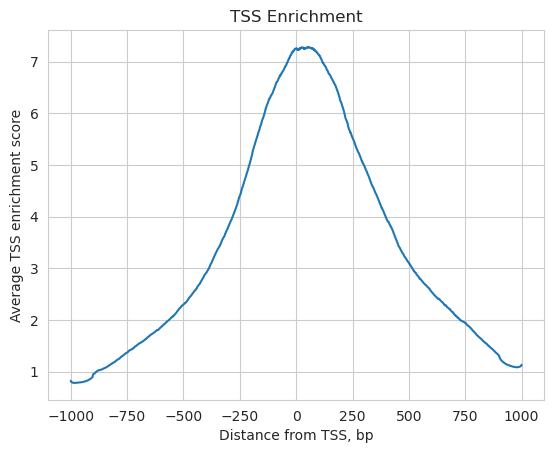

In [31]:
ac.pl.tss_enrichment(tss)

Overall one can see our data shows high enrichment of fragments around the TSS, which is an indicator for good data quality.
Again to see how this might differ in low quality cells, let's plot the enrichment of fragments around a TSS for cell with a low TSS scores. In comparison to the nucleosome signal, where high values represent low quality cells, here, we will filter out cells with a low TSS score.

In [34]:
# Choose threshold for the TSS and add information to atac.obs
tss_threshold = 1.5
tss.obs['tss_filter'] = ['TSS_FAIL' if score < tss_threshold else 'TSS_PASS' for
                                 score in atac.obs['tss_score'] ]

# Print number cells not passing nucleosome signal threshold
tss.obs['tss_filter'].value_counts()

TSS_PASS    124086
TSS_FAIL      7429
Name: tss_filter, dtype: int64

In [35]:
# wrapper function to allow fixed y-axis limiters
# makes it easier to compare the two classes of high and low quality cells
def plot_tss_ylim (data, title, ymin, ymax):
    
    _,axis = plt.subplots()
    axis.set_ylim(ymin,ymax)
    ac.pl.tss_enrichment(data, title=title, ax=axis)

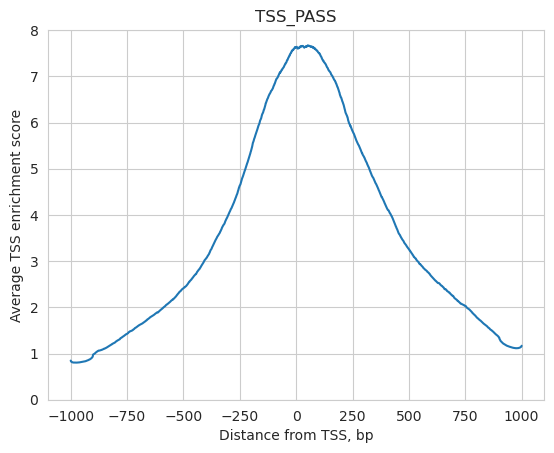

In [36]:
plot_tss_ylim(tss[tss.obs['tss_filter']=='TSS_PASS'], title='TSS_PASS', ymin=0, ymax=8)

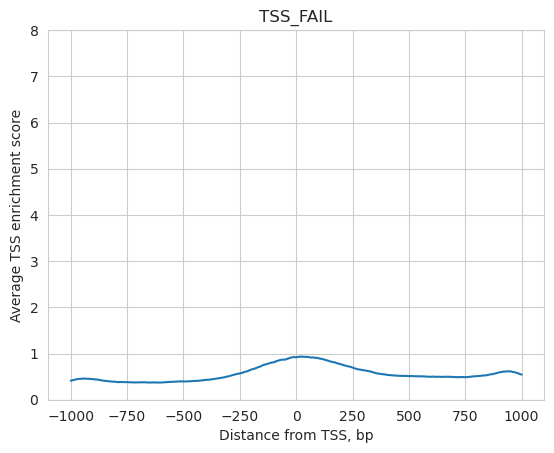

In [37]:
plot_tss_ylim(tss[tss.obs['tss_filter']=='TSS_FAIL'], title='TSS_FAIL', ymin=0, ymax=8)

We can see, how cells with low TSS scores show a much reduced enrichment of fragments around the TSS compared to high quality cells indicating a lower signal to noise ratio.

To make sure we don't lose are calculated QC values and to keep a version including all cells, lets save our current state of the adata object. Since the current version of AnnData doesn't allow to save slots with type ```OrderedDict```, we need to convert the two slots in ```atac.uns``` into a standard ```dict``` first. 

In [41]:
# Converting slots in adata.uns that are of type OrderedDict to dict to enable saving
atac.uns['atac'] = dict(atac.uns['atac'])
atac.uns['files'] = dict(atac.uns['files'])

Additionally, we want to save disc space by only saving the ```AnnData``` object without the RNA modality. To not loose the sample descriptions we defined at the beginning across modalities, we transfer them from ```mdata.obs``` to ```atac.obs```.

In [42]:
atac.obs['site'] = mdata.obs['site']
atac.obs['donor'] = mdata.obs['donor']
atac.obs['sample'] = mdata.obs['sample'] # refers to sample

In [46]:
# Printing the object we're about to save
atac

AnnData object with n_obs × n_vars = 131515 × 158155
    obs: 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'site', 'donor', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

Now, let's save the object.

In [45]:
# save after calculation of QC metrics
atac.write_h5ad('/lustre/groups/ml01/workspace/christopher.lance/mm_best/src/scATAC/muon_data/neurips_qc_unfiltered.h5ad')

# Sample level QC

As an inital check for entire samples with low quality, we check the number of cells and distributions of cell-level QC metrics across samples.

An first indicator for low quality samples can be the number of cells sequenced

In [47]:
# Get number of cells for each sample
n_cell_per_sample = atac.obs['sample'].value_counts()
# Print number per sample
n_cell_per_sample

s3d3     18732
s3d10    17521
s4d8     16934
s4d1     16337
s2d4     10062
s1d1      8442
s1d2      8341
s2d5      8246
s4d09     8217
s2d1      6319
s1d3      5626
s3d7      2734
s3d6      2355
s3d1      1649
Name: sample, dtype: int64

Text(0.5, 1.0, 'QC across samples')

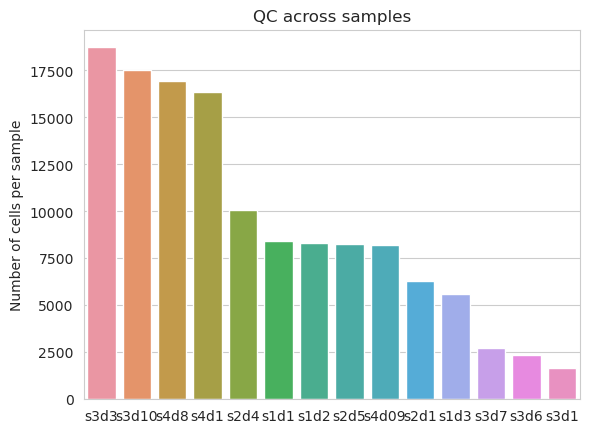

In [49]:
# Visualize as plot
sns.barplot(x = n_cell_per_sample.keys(), y=n_cell_per_sample.values, order=n_cell_per_sample.keys())
plt.ylabel('Number of cells per sample')
plt.title('QC across samples')

The above plot shows there are less cells captured for three sample of site 3 (s3d7, s3d6, s3d1), which can be an indicator for low sample quality due to issues in the sample preparation.

To get a further insight on the sample level, we plot the distribution of cell-level qc metrics.

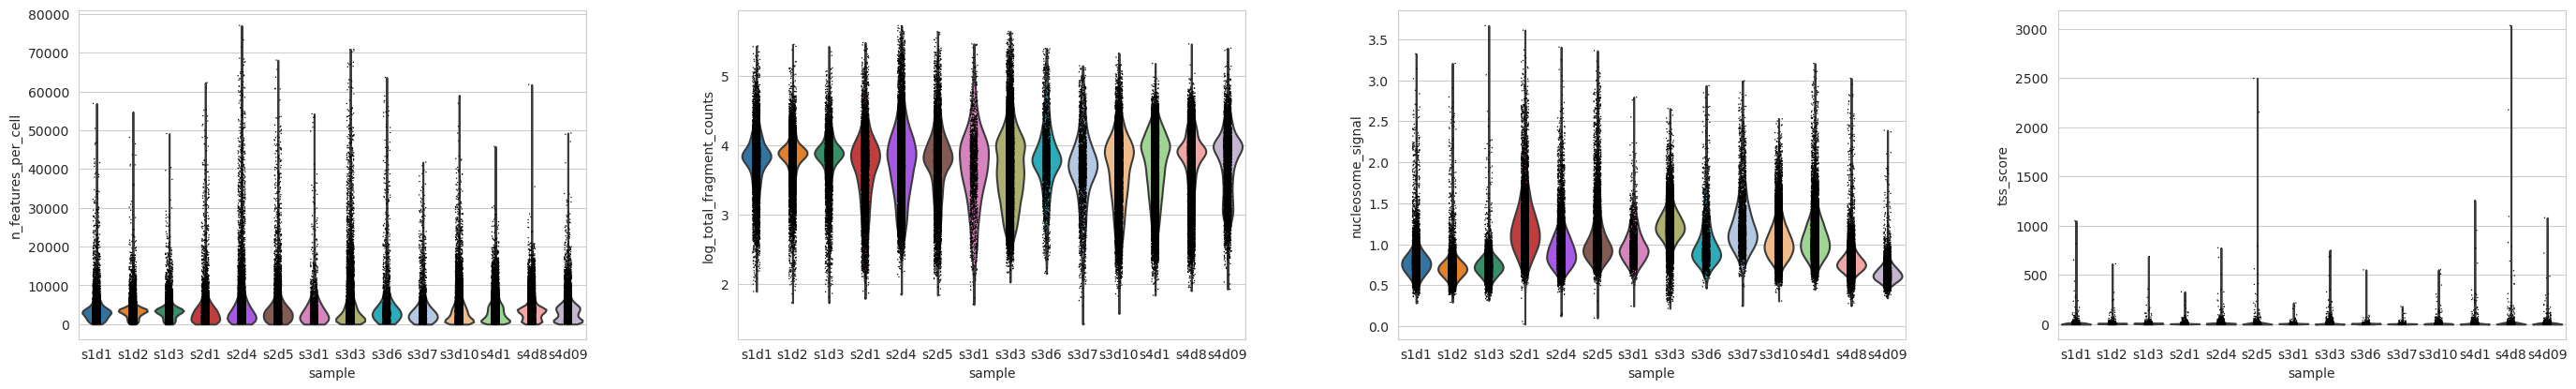

In [51]:
sc.pl.violin(atac, keys=['n_features_per_cell', 'log_total_fragment_counts', 'nucleosome_signal', 'tss_score'],
            groupby='sample')

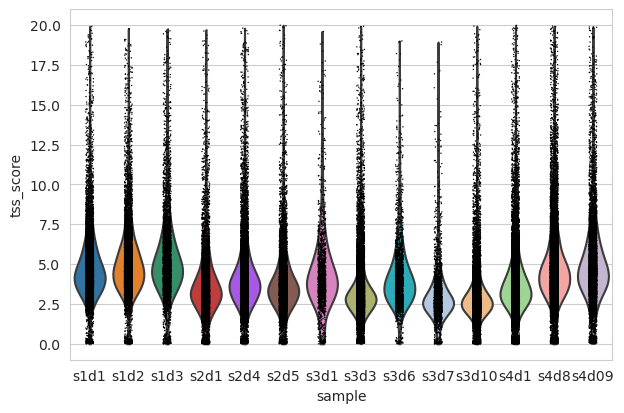

In [52]:
# Let's plot TSS scores <20 for easier comparison
sc.pl.violin(atac[atac.obs.tss_score<20,:], keys=['tss_score'],
            groupby='sample')

Based on the above plots there's not a clear indicator to remove any sample apart from lower cell count for three of the site three samples. Therefore, we don't exclude any sample, but keep in mind that there might be challenges during downstream processing.

Since the distribution of QC metrics is not identical across samples, it is highly recommended to perform cell level QC per sample, which follows next.

# Cell-level QC

First, let's get an idea of the distribution of QC metrics. The lines commented out generate plots for all samples, which are usefull to skimm through all samples. To not overload this notebook, we only plot thre of the 14 samples and discuss their interpretation.

In [68]:
# the subset of sample we use to showcase the analysis (s3d1 and s4d1)
atac_subset = atac[[s in ['s3d1', 's4d1', 's4d8'] for s in atac.obs['sample']],:]

**The full range of total fragment counts**

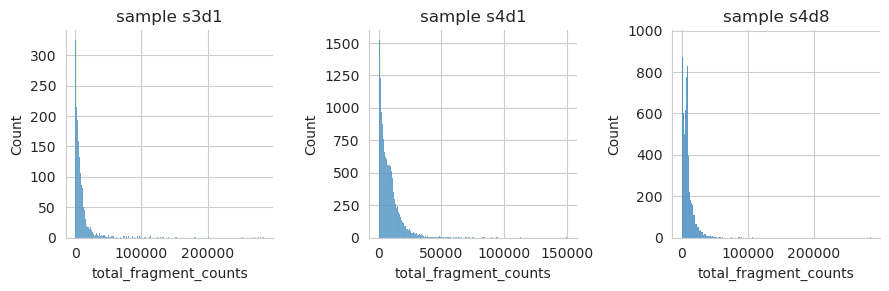

In [69]:
# Plot for all samples
#mu.pl.histogram(atac, ['total_fragment_counts'], groupby='sample')

# Plot 3 samples
mu.pl.histogram(atac_subset, ['total_fragment_counts'], groupby='sample')

This plot gives an overview of the range of the total number of fragments per cell. It becomes clear, that this metric if far from normally distributed and there are outlier cells with extremely high fragment counts that we will filter out.

**Zooming into the low count region**

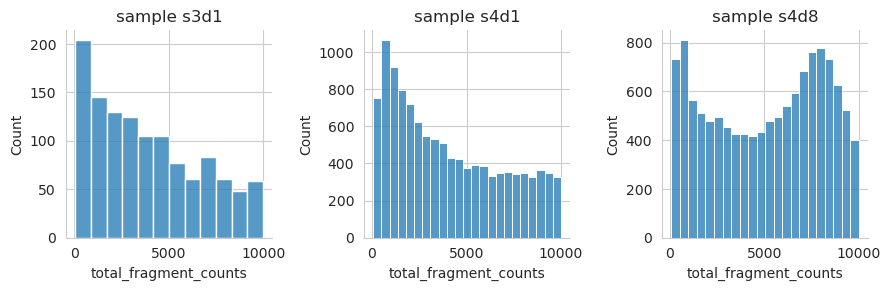

In [72]:
# Plot for all samples
#mu.pl.histogram(atac[atac.obs.total_fragment_counts<10000], ['total_fragment_counts'], groupby='sample')

# Plot 3 samples
mu.pl.histogram(atac_subset[atac_subset.obs.total_fragment_counts<10000], ['total_fragment_counts'], groupby='sample')

**ToDo** Description

**Checking the total number of detected features**

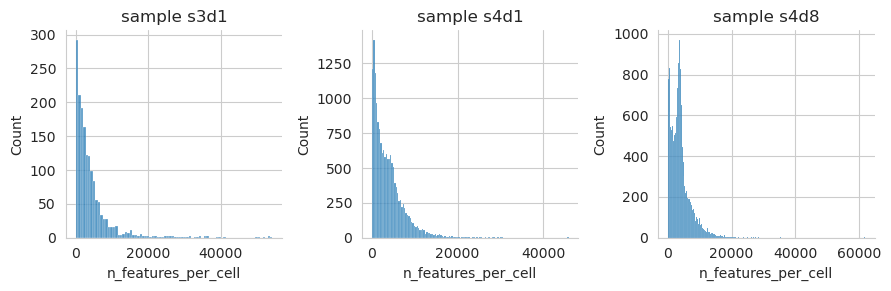

In [73]:
# Plot for all samples
#mu.pl.histogram(atac, ['n_features_per_cell'], groupby='sample')

# Plot 3 samples
mu.pl.histogram(atac_subset, ['n_features_per_cell'], groupby='sample')

**ToDo** Description

**Zooming into the lower counts to decide on lower cut offs**

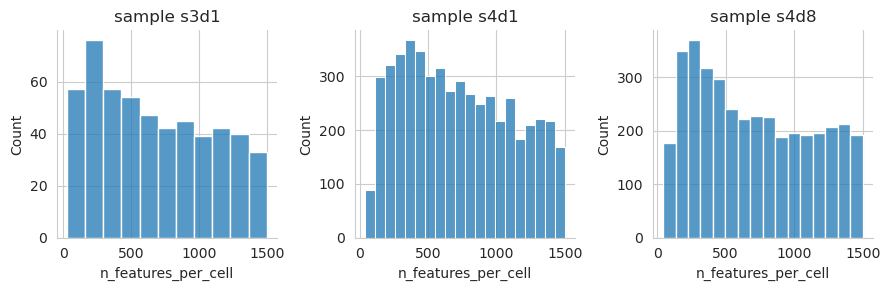

In [71]:
# Plot for all samples
#mu.pl.histogram(atac[atac.obs.n_features_per_cell<1500], ['n_features_per_cell'], groupby='sample')

# Plot 3 samples
mu.pl.histogram(atac_subset[atac_subset.obs.n_features_per_cell<1500], ['n_features_per_cell'], groupby='sample')

**ToDo** Description

To get an additional view mostly useful for the maximum cutoff of total counts, we plot the total fragment count against the total number of features across all samples. This is similar to the standard QC plot used in scRNA data quality control.

/lustre/groups/ml01/workspace/christopher.lance/miniconda3/envs/mm_best_muon_full/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


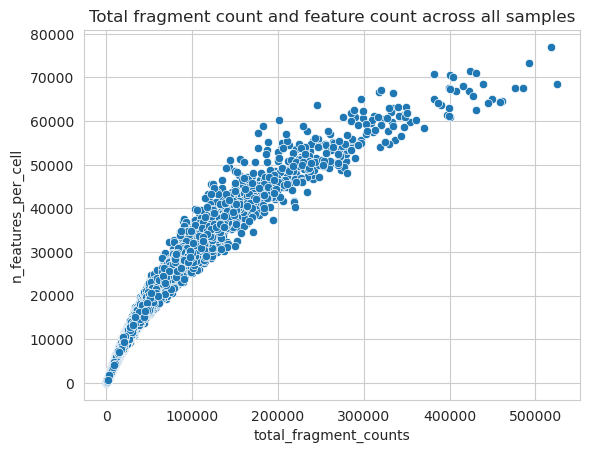

In [80]:
sns.scatterplot(atac.obs.total_fragment_counts,
                atac.obs.n_features_per_cell)
plt.title('Total fragment count and feature count across all samples')
plt.show()

The most common filtering step in scATAC data is based on the total number of counts plotted against the TSS enrichment score. Here, we chose a 2D hexbin plot. To not overload the notebook we only create the plot for two samples.

**ToDo** Better description

In [81]:
# boundaries for plotting
plot_tss_max = 20

# Initial thresholds
log_count_cutoff_lower = np.log10(1000)
log_count_cutoff_upper = np.log10(300000)
tss_cutoff = 1.5

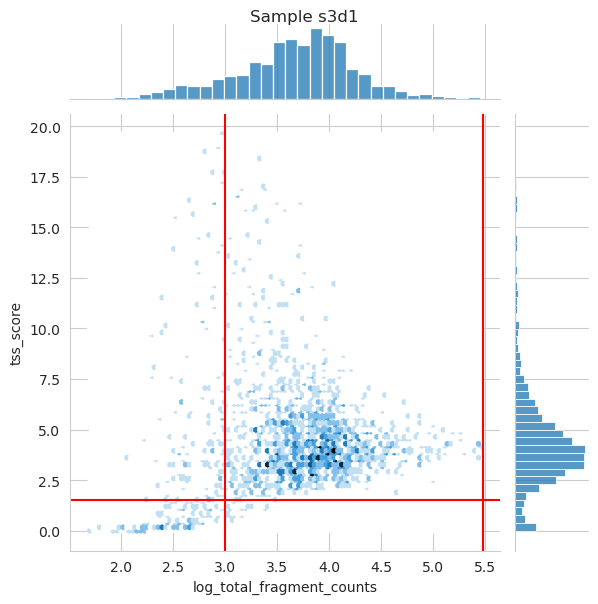

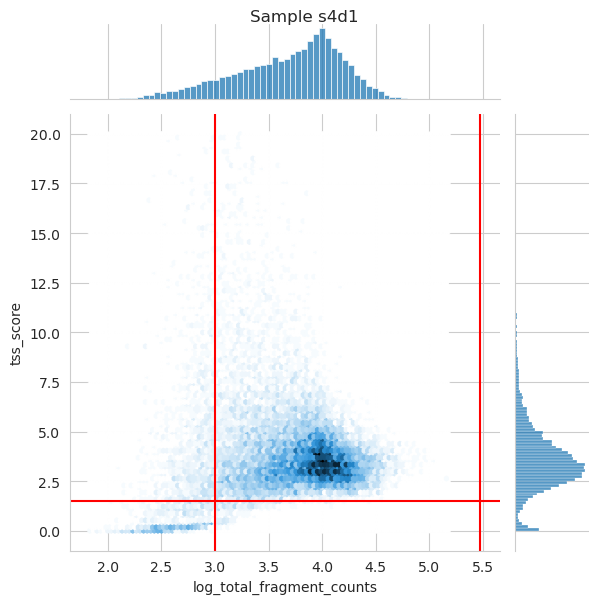

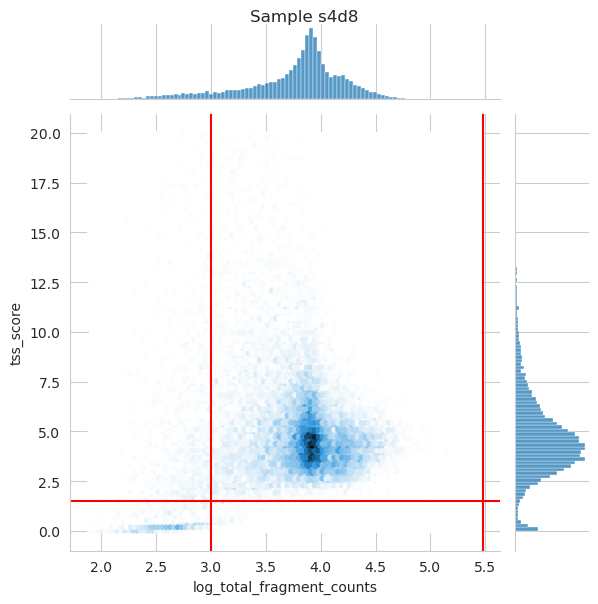

In [89]:
# plot for 3 samples
for s in list(atac_subset.obs['sample'].unique()):
    atac_samp = atac_subset[atac_subset.obs['sample']==s]
    sns.jointplot(data=atac_samp[(atac_samp.obs["tss_score"]<plot_tss_max)].obs,
                  x="log_total_fragment_counts",
                  y="tss_score",
                  kind='hex', gridsize=100)
    
    plt.axvline(x=log_count_cutoff_lower, c='red')
    plt.axvline(x=log_count_cutoff_upper, c='red')
    plt.axhline(y=tss_cutoff, c='red')
    
    plt.suptitle("Sample "+s, y = 1)


**ToDo** Update description

Across all samples, there is a distinct cluster in the bottom left corner, representing low quality cells. We have the fortunate situation, that thresholds for low quality cells are consitent across samples. This is not always the case, which can lead to different optimal thresholds for different samples.

However as one can see in the two plots above, there is still a difference in distribution of QC metrics between sample (narrow for sample 1, wider for sample 5). This might be an indicator, that sample 5 still contains lower quality cells should be considered in downstream processing tasks such as cell type annotation.

Taken together all the information form the QC plots, we next filter cells accordingly.

In [91]:
# Plot for all samples
# for s in list(atac.obs['sample'].unique()):
#     atac_samp = atac[atac.obs['sample']==s]
#     sns.jointplot(data=atac_samp[(atac_samp.obs["tss_score"]<plot_tss_max)].obs,
#                   x="log_total_fragment_counts",
#                   y="tss_score",
#                   kind='hex', gridsize=100)
#     
#     plt.axvline(x=log_count_cutoff_lower, c='red')
#     plt.axvline(x=log_count_cutoff_upper, c='red')
#     plt.axhline(y=tss_cutoff, c='red')
#     
#     plt.suptitle("Sample "+s, y = 1)
# 

# Filtering of cells and features

After inpecting the distribution of qc metrics, we select thresholds for filtering cells and features as follows:

**ToDo** Better description

- Features (peaks):
    - should be detected in at least 20 cells


In [92]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 20)

**ToDo** Better description and print how much cells were filtered out!

- Cells:
    - number of features per cell > 750
    - number of detected fragments > 1000 and < 300000
    - TSS score > 1.5
    - Nucleosome signal < 2

In [93]:
mu.pp.filter_obs(atac, 'n_features_per_cell', lambda x: x >= 750)
mu.pp.filter_obs(atac, 'log_total_fragment_counts', lambda x: (x >= log_count_cutoff_lower) & (x <= log_count_cutoff_upper))

In [94]:
mu.pp.filter_obs(atac, 'tss_score', lambda x: x >= tss_cutoff)
mu.pp.filter_obs(atac, 'nucleosome_signal', lambda x: x <= 2)

To ensure we keep a version of the raw counts we save them as a seperate layer.

In [95]:
# Save original counts
atac.layers["counts"] = atac.X

In [96]:
atac

AnnData object with n_obs × n_vars = 107712 × 158155
    obs: 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score', 'site', 'donor', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files', 'sample_colors'
    layers: 'counts'

Lastly, we save the filtered adata object.

In [97]:
atac.write_h5ad('/lustre/groups/ml01/workspace/christopher.lance/mm_best/src/scATAC/muon_data/neurips_qc_filtered_allsamp.h5ad')

## Take aways





**ToDo!**